In [1]:
# Install kagglehub
!pip install kagglehub

# Import required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

# Print dataset path
print("Dataset downloaded to:", path)


100%|██████████| 19.4M/19.4M [00:00<00:00, 78.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/uciml/electric-power-consumption-data-set/versions/1


## Load and Pre-Process Data

In [3]:
# Define dataset path (it might be inside a subdirectory)
file_path = os.path.join(path, "household_power_consumption.txt")

# Load dataset
df = pd.read_csv(file_path, sep=";", na_values="?", low_memory=False)

# Convert Date and Time to Datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Convert columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values (interpolation for time-series)
df.interpolate(method='time', inplace=True)

# Feature Engineering: Extract time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

# Display dataset summary
print(df.head())

                     Date  Time  Global_active_power  Global_reactive_power  \
Datetime                                                                      
2006-12-16 17:24:00   NaN   NaN                4.216                  0.418   
2006-12-16 17:25:00   NaN   NaN                5.360                  0.436   
2006-12-16 17:26:00   NaN   NaN                5.374                  0.498   
2006-12-16 17:27:00   NaN   NaN                5.388                  0.502   
2006-12-16 17:28:00   NaN   NaN                3.666                  0.528   

                     Voltage  Global_intensity  Sub_metering_1  \
Datetime                                                         
2006-12-16 17:24:00   234.84              18.4             0.0   
2006-12-16 17:25:00   233.63              23.0             0.0   
2006-12-16 17:26:00   233.29              23.0             0.0   
2006-12-16 17:27:00   233.74              23.0             0.0   
2006-12-16 17:28:00   235.68              15.8    

## Normalize Data & Split for Machine Learning


In [4]:
# Select features & target
features = ['Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'dayofweek']
target = 'Global_active_power'

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features + [target]])

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features + [target])

# Split into train/test
X = df_scaled[features].values
y = df_scaled[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train a Neural Network for Energy Prediction

In [5]:
# Build NN model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - loss: 5.5202e-05 - mae: 0.0036 - val_loss: 1.3705e-05 - val_mae: 0.0026
Epoch 2/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - loss: 1.2846e-05 - mae: 0.0024 - val_loss: 1.3487e-05 - val_mae: 0.0024
Epoch 3/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - loss: 1.2284e-05 - mae: 0.0024 - val_loss: 1.0882e-05 - val_mae: 0.0021
Epoch 4/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - loss: 1.1918e-05 - mae: 0.0023 - val_loss: 1.1011e-05 - val_mae: 0.0022
Epoch 5/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - loss: 1.1937e-05 - mae: 0.0023 - val_loss: 1.2155e-05 - val_mae: 0.0023
Epoch 6/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - loss: 1.1774e-05 - mae: 0.0023 - val_loss: 1.0726e-05 - val_mae: 0.0021
Epoch 7/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - loss: 1.1514e-05 - mae: 0.0023 - val_loss: 1.1511e-05 - val_mae: 0.0024
Epoch 8/20
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 116s 2ms/step - loss: 1.1325e-05

## Predict & Evaluate Model

12971/12971 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


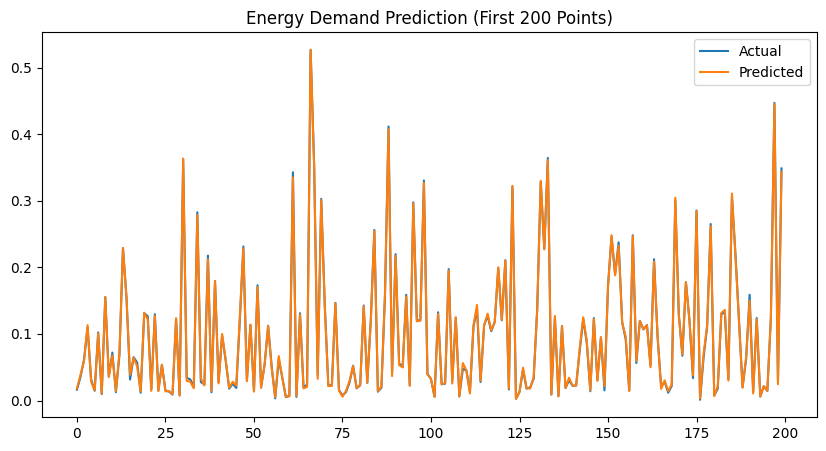

In [6]:
# Predict on test data
y_pred = model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("Energy Demand Prediction (First 200 Points)")
plt.show()

In [11]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

y_test shape: (415052,)
y_pred shape: (415052, 1)


In [12]:
y_pred = y_pred.flatten()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print Scores
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0021
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0032
R² Score: 0.9989


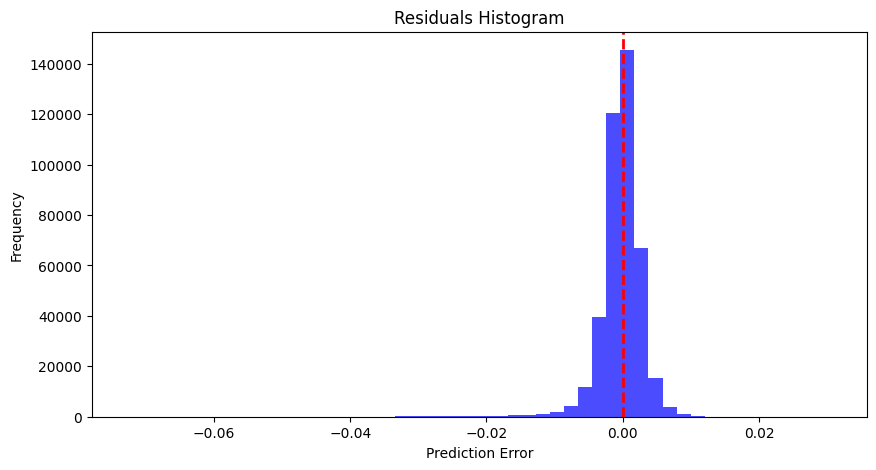

In [14]:
import matplotlib.pyplot as plt

# Calculate Residuals
residuals = y_test - y_pred

# Plot Residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color="blue", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="dashed", linewidth=2)
plt.title("Residuals Histogram")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

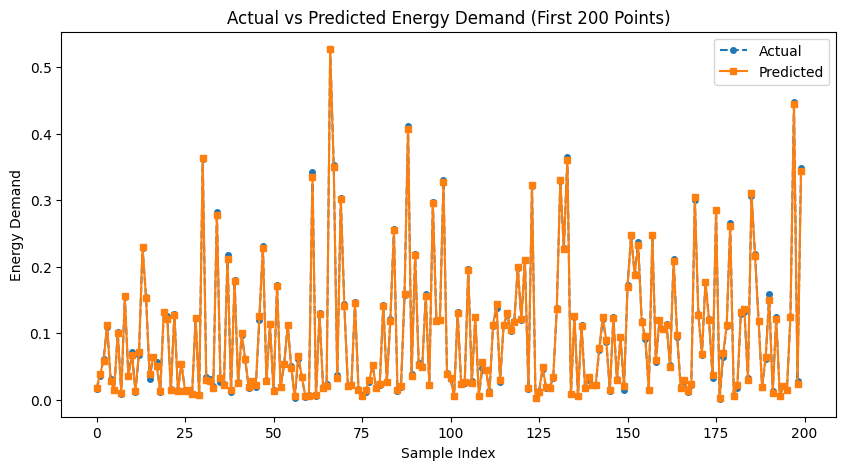

In [15]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label="Actual", marker="o", linestyle="dashed", markersize=4)
plt.plot(y_pred[:200], label="Predicted", marker="s", linestyle="solid", markersize=4)
plt.legend()
plt.title("Actual vs Predicted Energy Demand (First 200 Points)")
plt.xlabel("Sample Index")
plt.ylabel("Energy Demand")
plt.show()

## Implement an LSTM for Time-Series Forecasting
Since energy usage is time-dependent, we upgrade to LSTMs.

In [7]:
# Convert Data into Sequential Format for LSTM
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 24  # Use 24 hours of past data to predict the next hour
X_seq, y_seq = create_sequences(df_scaled.values, seq_length)

# Split into train/test
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

## Train an LSTM Model

In [8]:
# Build LSTM Model
lstm_model = keras.Sequential([
    layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])),
    layers.LSTM(32, activation='relu'),
    layers.Dense(1)  # Output layer
])

# Compile & Train
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_lstm = lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 289s 5ms/step - loss: 6.6734e-04 - mae: 0.0124 - val_loss: 4.9095e-04 - val_mae: 0.0119
Epoch 2/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 279s 5ms/step - loss: 4.6820e-04 - mae: 0.0096 - val_loss: 4.4857e-04 - val_mae: 0.0087
Epoch 3/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 281s 5ms/step - loss: 4.4640e-04 - mae: 0.0093 - val_loss: 4.5917e-04 - val_mae: 0.0112
Epoch 4/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 280s 5ms/step - loss: 4.3222e-04 - mae: 0.0090 - val_loss: 4.2396e-04 - val_mae: 0.0103
Epoch 5/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 280s 5ms/step - loss: 4.2332e-04 - mae: 0.0089 - val_loss: 4.1164e-04 - val_mae: 0.0086
Epoch 6/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 280s 5ms/step - loss: 4.1577e-04 - mae: 0.0087 - val_loss: 4.0234e-04 - val_mae: 0.0084
Epoch 7/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 281s 5ms/step - loss: 4.1056e-04 - mae: 0.0086 - val_loss: 4.0447e-04 - val_mae: 0.0085
Epoch 8/10
51881/51881 ━━━━━━━━━━━━━━━━━━━━ 280s 5ms/step - loss: 4.0536e-04

## Predict with LSTM

12971/12971 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step


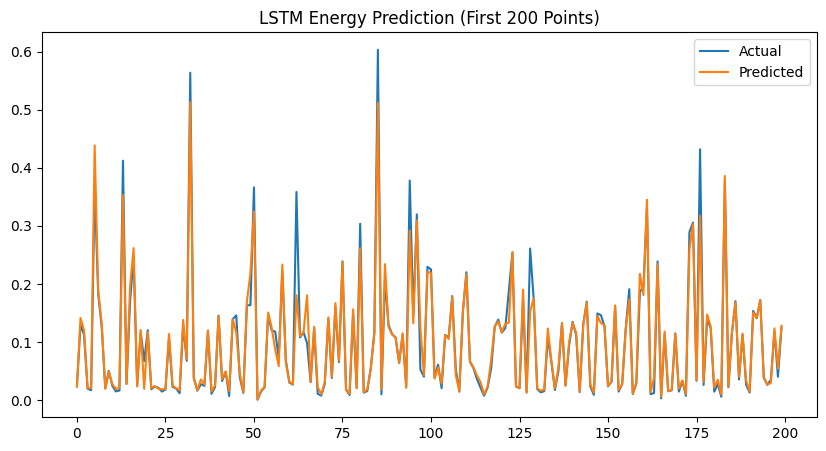

In [9]:
# Predict on test data
y_pred_lstm = lstm_model.predict(X_test_seq)

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_seq[:200], label="Actual")
plt.plot(y_pred_lstm[:200], label="Predicted")
plt.legend()
plt.title("LSTM Energy Prediction (First 200 Points)")
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Ensure predictions are in the correct shape
y_pred_lstm = y_pred_lstm.flatten()

# Compute evaluation metrics
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

# Create a summary of results
lstm_metrics = {
    "Mean Absolute Error (MAE)": mae_lstm,
    "Mean Squared Error (MSE)": mse_lstm,
    "Root Mean Squared Error (RMSE)": rmse_lstm,
    "R² Score": r2_lstm
}

# Convert results into DataFrame for display
lstm_results_df = pd.DataFrame(lstm_metrics, index=["LSTM Model"])

# Display results
print(lstm_results_df)


            Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
LSTM Model                   0.008078                   0.00039   

            Root Mean Squared Error (RMSE)  R² Score  
LSTM Model                        0.019745  0.957191  
